** Data crunching ** 

In [1]:
import pandas as pd
import numpy as np
        
data = pd.read_csv('../data/4A_201701_Consistent.csv', sep=';')

# Initial data-slicing
data = data[(data.LinkTravelTime > 0) & (data.LineDirectionCode == 1)]

# Data convertion
data['DateTime'] = pd.to_datetime(data['DateTime'])
time = pd.DatetimeIndex(data['DateTime']) 
data['TimeOfDayClass'] = 'NO_PEEK' 
data['Hour'] = time.hour
data.ix[((7 < time.hour) & (time.hour < 9) & (data['DayType'] == 1)), 'TimeOfDayClass'] = 'PEEK' 
data.ix[((15 < time.hour) & (time.hour < 17) & (data['DayType'] == 1)), 'TimeOfDayClass'] = 'PEEK' 
data = data[(27 <= data.LineDirectionLinkOrder) & (data.LineDirectionLinkOrder <= 27)]

data = data.sort_values("DateTime", ascending=False)
data = data.set_index(np.arange(0,data.shape[0],1))

** Plot time series ** 

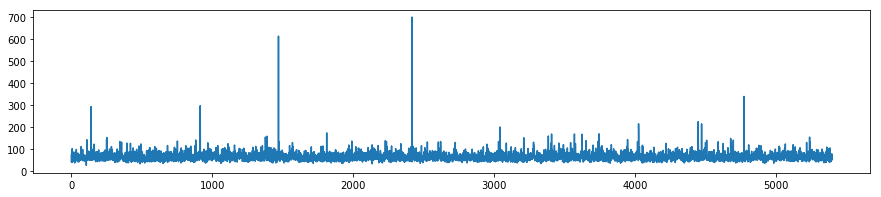

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,3))
plt.plot(data.LinkTravelTime.values)


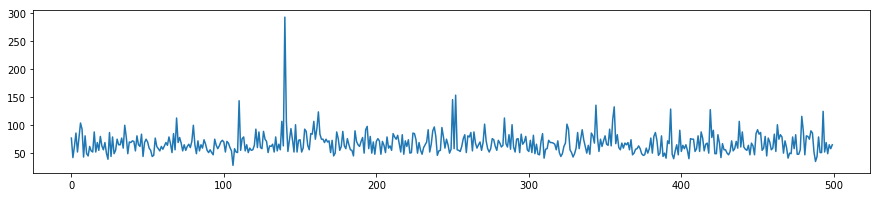

In [3]:
plt.figure(figsize=(15,3))
plt.plot(data.LinkTravelTime.values[0:500])

In [4]:
temp = data.sort_values("LinkTravelTime", ascending=False)
temp[temp.columns[8:10]].head()

,LinkTravelTime,TimeOfDayClass
2417,698.0,PEEK
1469,612.0,PEEK
4771,339.0,PEEK
914,297.0,PEEK
140,293.0,NO_PEEK


** Generate feature matrix**

In [5]:
num_lags = 20
target = []
lags = []
timeOfday = []
for i in range(data.shape[0]):
    target.append(data.iloc[i].LinkTravelTime)
    lags.append(data.LinkTravelTime.shift(-1)[i:i+num_lags].values)
    timeOfday.append(data.iloc[i].TimeOfDayClass)
    
mat = pd.DataFrame(lags)
mat["timeOfDay"] = timeOfday
mat = pd.get_dummies(mat)
mat["ground_truth"] = target
mat = mat.dropna(axis=0)

mat = np.array(mat)

X = mat[:, 0:num_lags+2]
y = mat[:, num_lags+2]

# Split data into train and test    
X_train, X_test = np.split(X, [int(.8*len(X))])
y_train, y_test = np.split(y, [int(.8*len(y))])


** Linear Regression **

In [6]:
from sklearn import linear_model

# Train
clf = linear_model.LinearRegression()
clf.fit(X_train, y_train) 
y_train_pred = clf.predict(X_train)
train_rmse = np.sqrt(np.mean((np.array(y_train_pred) - np.array(y_train))**2))
print "Lr train error: %f" % train_rmse

# Test
y_test_pred = clf.predict(X_test)
test_rmse = np.sqrt(np.mean((np.array(y_test_pred) - np.array(y_test))**2))
print "Lr test error: %f" % test_rmse

Lr train error: 22.029285
Lr test error: 19.347517


** Support Vector Regression **

In [7]:
from sklearn.svm import SVR

# Train
clf = SVR()
clf.fit(X_train, y_train) 
y_train_pred = clf.predict(X_train)
train_rmse = np.sqrt(np.mean((np.array(y_train_pred) - np.array(y_train))**2))
print "SVR train error: %f" % train_rmse
    
# Test
y_test_pred = clf.predict(X_test)
test_rmse = np.sqrt(np.mean((np.array(y_test_pred) - np.array(y_test))**2))
print "SVR test error: %f" % test_rmse

SVR train error: 22.017859
SVR test error: 19.951302


** LSTM ** 

In [8]:
import tensorflow as tf
import functools

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper

class LstmConfig:

    def __init__(self):

        self.batch_size = 256
        self.seq_len = 20
        self.learning_rate = 0.01
        self.state_size = 128
        self.num_layers = 1
        self.num_epochs = 5
        self.dropout_train = 0.25
        self.dropout_eval = 1

class LstmModel:

    def __init__(self, config):

        self.config = config
        self.add_placeholders()

    def add_placeholders(self):

        self.input_placeholder = tf.placeholder(tf.float32, [None, self.config.seq_len, 1], "input")
        self.dropout_placeholder = tf.placeholder(tf.float32)
        self.target_placeholder = tf.placeholder(tf.float32, [None, 1], "target")

    def add_LSTM_layer(self):

        onecell = tf.contrib.rnn.GRUCell(self.config.state_size)
        onecell = tf.contrib.rnn.DropoutWrapper(onecell, output_keep_prob=self.dropout_placeholder)            
        multicell = tf.contrib.rnn.MultiRNNCell([onecell] * self.config.num_layers, state_is_tuple=False)

        outputs, _ = tf.nn.dynamic_rnn(multicell, self.input_placeholder, dtype=tf.float32)
        return outputs
        
    def add_dense_layer(self, _input, hidden_size, out_size):

        weight = tf.Variable(tf.truncated_normal([hidden_size, out_size], stddev=0.01))
        bias = tf.Variable(tf.constant(0.1, shape=[out_size]))
        return tf.matmul(_input, weight) + bias

    @lazy_property
    def cost(self):
        
        mse = tf.sqrt(tf.reduce_mean(tf.pow(tf.subtract(self.prediction, self.target_placeholder), 2.0)))
        return mse

    @lazy_property
    def optimize(self):
        
        optimizer = tf.train.RMSPropOptimizer(self.config.learning_rate)
        return optimizer.minimize(self.cost)

    def batch_train_generator(self, X, y):
        
        for i in range(len(X) // self.config.batch_size):
            batch_X = X[i:i+self.config.batch_size, :]
            batch_y = y[i:i+self.config.batch_size]

            yield batch_X, batch_y

    def run_epochs(self, X_train, y_train, X_test):

        last_output = self.add_LSTM_layer()
        last_output = last_output[:, last_output.shape[1] - 1, :]
        last_output = self.add_dense_layer(last_output, self.config.state_size, 1)
        self.prediction = last_output
        self.optimize

        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(self.config.num_epochs):
            # mini batch generator for training
            gen_train = self.batch_train_generator(X_train, y_train)

            for batch in range(len(X_train) // self.config.batch_size):

                batch_X, batch_y = next(gen_train);
                _ = sess.run(self.optimize, feed_dict={
                        self.input_placeholder: batch_X.reshape(-1, self.config.seq_len, 1),
                        self.target_placeholder: batch_y.reshape(-1, 1),
                        self.dropout_placeholder: self.config.dropout_train
                })

            train_error = sess.run(self.cost, feed_dict={
                    self.input_placeholder: X_train.reshape(-1, self.config.seq_len, 1),
                    self.target_placeholder: y_train.reshape(-1, 1),
                    self.dropout_placeholder: self.config.dropout_eval
            })
            
            print "Epoch: %d, train rmse: %f" %(epoch+1, train_error)

        
        preds = sess.run(self.prediction, feed_dict={
                self.input_placeholder: X_test.reshape(-1, self.config.seq_len, 1),
                self.dropout_placeholder: self.config.dropout_eval
        })

        return preds

def main():
    
    X = mat[:, 0:num_lags]
    y = mat[:, num_lags+2]
    
    # Split data into train and test    
    X_train, X_test = np.split(X, [int(.8*len(X))])
    y_train, y_test = np.split(y, [int(.8*len(y))])

    config = LstmConfig()
    model = LstmModel(config)
    preds = model.run_epochs(X_train, y_train, X_test)
    test_rmse = np.sqrt(np.mean((np.array(preds) - np.array(y_test))**2))
    print "LSTM Test rmse: %f" % test_rmse
    
main()

Epoch: 1, train rmse: 57.602264
Epoch: 2, train rmse: 43.367558
Epoch: 3, train rmse: 30.536625
Epoch: 4, train rmse: 23.382828
Epoch: 5, train rmse: 22.423916
LSTM Test rmse: 19.716058
